# Multiple RFE results analysis

In [1]:
import numpy as np
from pathlib import Path
from typing import Dict, Any, List, Iterable, Optional
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import itertools
from collections import Counter


In [2]:
# =============================================================================
# Helpers
# =============================================================================

def feat_id(d: Dict[str, Any]) -> str:
    """Compact feature id: feature_key-granularity_key-encoding_key."""
    return f"{d.get('feature_key', '')} / {d.get('granularity_key', '')} / {d.get('encoding_key', '')}"


def _load_records(path: Path) -> List[Dict[str, Any]]:
    """Load JSON list of records from a given path."""
    if not isinstance(path, Path):
        path = Path(path)
    if not path.exists():
        raise FileNotFoundError(f"RFE results not found: {path}")
    with path.open("r", encoding="utf-8") as f:
        records = json.load(f)
    if not isinstance(records, list) or not records:
        raise RuntimeError(f"No records found in RFE results JSON: {path}")
    return records


# =============================================================================
# Build per-dataset base table (compatible with single-experiment rank_df)
# =============================================================================

def build_rank_df_for_records(records: List[Dict[str, Any]], dataset: str) -> pd.DataFrame:
    """
    Build consolidated base dataset for ONE experiment, then tag with dataset.

    Columns:
    --------
    feature_id, feature_key, granularity_key, encoding_key,
    iteration_removed, timestamp_utc, metrics, importance_rank, dataset
    """
    eliminated_rows: List[Dict[str, Any]] = []
    all_feats: set[str] = set()
    
    for idx, rec in enumerate(records, start=1):
        metric_key = rec.get("metric_key")
        baseline_metric = rec.get("baseline_metric_value", {})

        for elim in rec.get("eliminated_features", []) or []:
            eliminated_rows.append({
                "feature_id": feat_id(elim),
                "feature_key": elim.get("feature_key"),
                "encoding_key": elim.get("encoding_key"),
                "granularity_key": elim.get("granularity_key"),
                "iteration_removed": idx,
                "timestamp_utc": rec.get("timestamp_utc"),
                "eliminated_feat_metric": elim.get("metrics", {}).get(metric_key, {}),
                "baseline_metric": baseline_metric,
                "metric_key": metric_key,
            })
        
        for f in rec.get("remaining_elimination_features", []) or []:
            all_feats.add(feat_id(f))

    max_iter = len(records)
    elim_df = pd.DataFrame(eliminated_rows)

    # Features never eliminated ⇒ highest importance bucket
    not_removed_ids = sorted(list(all_feats - set(elim_df["feature_id"].tolist() if not elim_df.empty else [])))
    not_removed_rows: List[Dict[str, Any]] = []
    for fid in not_removed_ids:
        parts = fid.split("-", 2)
        not_removed_rows.append({
            "feature_id": fid,
            "feature_key": parts[0] if len(parts) > 0 else "",
            "granularity_key": parts[1] if len(parts) > 1 else "",
            "encoding_key": parts[2] if len(parts) > 2 else "",
            "iteration_removed": max_iter + 1,
            "timestamp_utc": None,
            "eliminated_feat_metric": None,
            "baseline_metric": None,
            "metric_key": metric_key,
        })

    not_removed_df = pd.DataFrame(not_removed_rows)

    if elim_df.empty and not_removed_df.empty:
        raise RuntimeError(f"No features found in RFE results for dataset={dataset}")

    rank_df = pd.concat([elim_df, not_removed_df], ignore_index=True, sort=False)
    rank_df = rank_df.sort_values("iteration_removed").reset_index(drop=True)
    rank_df["importance_rank"] = rank_df["iteration_removed"].rank(method="dense", ascending=True).astype(int)
    rank_df["dataset"] = dataset
    return rank_df


def build_multi_rank_df(dataset_paths: Dict[str, tuple[Path, str, str]]) -> pd.DataFrame:
    """
    Load multiple experiments and stack their rank tables with additional metadata.

    Parameters
    ----------
    dataset_paths : dict[str, tuple[Path, str, str]]
        Mapping of dataset label → (json_path, case_duration, cyclicality).

    Returns
    -------
    pd.DataFrame
        Combined rank_df with columns:
        feature_id, feature_key, granularity_key, encoding_key,
        iteration_removed, timestamp_utc, metrics, importance_rank,
        dataset, period, aggregation
    """
    frames: List[pd.DataFrame] = []
    for name, (path, case_duration, cyclicality, complexity, std) in dataset_paths.items():
        records = _load_records(path)
        df = build_rank_df_for_records(records, dataset=name)
        df["case_duration"] = case_duration
        df["cyclicality"] = cyclicality
        df["complexity"] = complexity
        df["std"] = std
        frames.append(df)
    rank_df_multi = pd.concat(frames, ignore_index=True, sort=False)
    return rank_df_multi



# =============================================================================
# Average Importance Rank Plotting (Clustered + Pooled, 1D/2D/3D)
# =============================================================================

def _validate_keys(rank_df_multi: pd.DataFrame, keys: Iterable[str]) -> None:
    """Ensure requested grouping keys exist in the DataFrame."""
    for k in keys:
        if k not in rank_df_multi:
            raise ValueError(f"Key '{k}' missing from rank_df_multi")


def _combo_label_df(df: pd.DataFrame, keys: list[str]) -> pd.Series:
    """Generate combined label for multiple grouping keys."""
    return df[keys].astype(str).agg(" | ".join, axis=1)


def _apply_orders(df: pd.DataFrame, orders: Optional[dict]) -> pd.DataFrame:
    """Apply categorical ordering to DataFrame columns."""
    if not orders:
        return df
    dd = df.copy()
    for k, order in orders.items():
        if order is not None and k in dd.columns:
            dd[k] = pd.Categorical(dd[k], categories=order, ordered=True)
    return dd


def _aggregate_importance(
    rank_df_multi: pd.DataFrame,
    keys: list[str],
    agg: str,
    pooled: bool
) -> pd.DataFrame:
    """Aggregate importance ranks by keys (+ dataset if not pooled)."""
    _validate_keys(rank_df_multi, keys)
    if agg not in {"mean", "median"}:
        raise ValueError("agg must be 'mean' or 'median'")
    group_keys = keys if pooled else keys + ["dataset"]
    df = (
        rank_df_multi
        .groupby(group_keys, dropna=False)["importance_rank"]
        .agg(agg)
        .reset_index()
    )
    return df


# =============================================================================
# Main Plotting Function
# =============================================================================

def plot_importance_rank(
    rank_df_multi: pd.DataFrame,
    keys: str | list[str] = "feature_key",
    orders: Optional[dict] = None,
    agg: str = "mean",
    kind: str = "bar",       # "bar" or "box"
    pooled: bool = False,    # False = clustered by dataset, True = pooled
    top_n: Optional[int] = None,
    figsize: tuple = (14, 6)
) -> None:
    """
    General plotting function for Average Importance Ranks, supporting
    correct categorical ordering including dataset order.

    Parameters
    ----------
    rank_df_multi : pd.DataFrame
        The stacked rank_df with dataset column.
    keys : str or list[str]
        Dimension(s) to group by: 'feature_key', 'granularity_key', 'encoding_key'.
        Supports 1D, 2D, or 3D.
    orders : dict, optional
        Category orders per key, e.g. {'feature_key': [...], 'dataset': [...]}.
    agg : {'mean','median'}
        Aggregation for bar plots.
    kind : {'bar','box'}
        Chart type.
    pooled : bool, default=False
        If True, pool across datasets. If False, cluster by dataset.
    top_n : int, optional
        Show only top N combos (lowest ranks).
    figsize : tuple
        Figure size.
    """
    if isinstance(keys, str):
        keys = [keys]
    _validate_keys(rank_df_multi, keys)

    # ============== aggregation ==============
    if kind == "bar":
        df = _aggregate_importance(rank_df_multi, keys, agg, pooled)
    else:
        df = rank_df_multi.copy()

    # Apply category orders
    df = _apply_orders(df, orders)

    # Dataset ordering if provided
    dataset_order = None
    if not pooled and orders and "dataset" in orders:
        dataset_order = orders["dataset"]
        if "dataset" in df.columns:
            df["dataset"] = pd.Categorical(df["dataset"], categories=dataset_order, ordered=True)

    # Add combo label if multiple keys
    if len(keys) > 1:
        df["combo"] = _combo_label_df(df, keys)
        group_col = "combo"
    else:
        group_col = keys[0]

    # ============== determine category order ==============
    if kind == "bar":
        if orders and group_col in orders:
            categories = orders[group_col]
        else:
            sort_vals = (
                df.groupby(group_col)["importance_rank"]
                .mean()
                .sort_values(ascending=True)
            )
            categories = sort_vals.index.tolist()
        if top_n is not None:
            categories = categories[:top_n]
        df = df[df[group_col].isin(categories)]
        df[group_col] = pd.Categorical(df[group_col], categories=categories, ordered=True)

    elif kind == "box":
        if orders and group_col in orders:
            categories = orders[group_col]
        else:
            pooled_means = (
                df.groupby(group_col)["importance_rank"]
                .mean()
                .sort_values(ascending=True)
            )
            categories = pooled_means.index.tolist()
        if top_n is not None:
            categories = categories[:top_n]
        df = df[df[group_col].isin(categories)]
        df[group_col] = pd.Categorical(df[group_col], categories=categories, ordered=True)

    # ============== plotting ==============
    plt.figure(figsize=figsize)
    title = f"{agg.capitalize()} Importance Rank" if kind == "bar" else "Distribution of Importance Ranks"
    subtitle = "pooled across datasets" if pooled else "clustered by dataset"
    label = " × ".join(keys)

    if _HAS_SNS:
        if kind == "bar":
            if pooled:
                sns.barplot(data=df, x=group_col, y="importance_rank", ci=None, order=categories)
            else:
                sns.barplot(
                    data=df,
                    x=group_col,
                    y="importance_rank",
                    hue="dataset",
                    ci=None,
                    order=categories,
                    hue_order=dataset_order,
                )
        else:
            if pooled:
                sns.boxplot(data=df, x=group_col, y="importance_rank", order=categories)
            else:
                sns.boxplot(
                    data=df,
                    x=group_col,
                    y="importance_rank",
                    hue="dataset",
                    order=categories,
                    hue_order=dataset_order,
                )
    else:
        # matplotlib fallback
        cats = categories
        if kind == "bar":
            if pooled:
                vals = [df[df[group_col] == c]["importance_rank"].mean() for c in cats]
                plt.bar(cats, vals)
            else:
                datasets = (
                    dataset_order
                    if dataset_order is not None
                    else df["dataset"].astype(str).unique().tolist()
                )
                idx = np.arange(len(cats))
                width = 0.8 / max(1, len(datasets))
                for i, ds in enumerate(datasets):
                    vals = [
                        df[(df[group_col] == c) & (df["dataset"] == ds)]["importance_rank"].mean()
                        for c in cats
                    ]
                    plt.bar(idx + i * width, vals, width=width, label=ds)
                plt.xticks(idx + (len(datasets) - 1) * width / 2, cats, rotation=90)
                plt.legend(title="dataset")
        else:
            data = [df[df[group_col] == c]["importance_rank"] for c in cats]
            plt.boxplot(data, labels=cats)

    plt.title(f"{title} — {label} ({subtitle})")
    plt.xlabel(label)
    plt.ylabel("Importance Rank")
    plt.xticks(rotation=90 if len(keys) > 1 else 45, ha="right")
    plt.tight_layout()
    plt.show()

def plot_heatmap(pivot, title=None, xlabel=None, ylabel=None, cmap="RdYlGn", size=(7,5), center=None, min=None, max=None):
    plt.figure(figsize=size)
    sns.heatmap(
        pivot.T,
        annot=True,           # show lift values in each cell
        cmap=cmap,        # red = low, green = high lift
        center=center,           # center the color map at neutral lift = 0
        vmin=min,
        vmax=max,
        fmt=".1f",
    )

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()



In [3]:
DATASETS = {
    '12h / none / simple/ low': (Path('../artifacts/recursive_feature_elimination/syn/syn_12h_none_0-25/pi_rfe_results_20251014T130053Z.json'), '12h', 'none', 'simple', 'low'),
    '12h / daily / simple / low': (Path('../artifacts/recursive_feature_elimination/syn/syn_12h_daily0-3_0-25/pi_rfe_results_20251021T143631Z.json'), '12h', 'daily', 'simple', 'low'),
    '12h / weekly / simple / low': (Path('../artifacts/recursive_feature_elimination/syn/syn_12h_weekly0-2_0-25/pi_rfe_results_20251021T175156Z.json'), '12h', 'weekly', 'simple', 'low'),
    '12h / monthly / simple / low': (Path('../artifacts/recursive_feature_elimination/syn/syn_12h_monthly0-2_0-25/pi_rfe_results_20251021T212725Z.json'), '12h', 'monthly', 'simple', 'low'),
    '12h / yearly / simple / low': (Path('../artifacts/recursive_feature_elimination/syn/syn_12h_yearly0-2_0-25_7y/pi_rfe_results_20251022T171121Z.json'), '12h', 'yearly', 'simple', 'low'),

    '3.5d / none / simple / low': (Path('../artifacts/recursive_feature_elimination/syn/syn_3-5d_none_0-25/pi_rfe_results_20251014T134737Z.json'), '3.5d', 'none', 'simple', 'low'),
    '3.5d / daily / simple / low': (Path('../artifacts/recursive_feature_elimination/syn/syn_3-5d_daily0-6_0-25/pi_rfe_results_20251021T102821Z.json'), '3.5d', 'daily', 'simple', 'low'),
    '3.5d / weekly / simple / low': (Path('../artifacts/recursive_feature_elimination/syn/syn_3-5d_weekly0-6_0-25/pi_rfe_results_20251021T130648Z.json'), '3.5d', 'weekly', 'simple', 'low'),
    '3.5d / monthly / simple / low': (Path('../artifacts/recursive_feature_elimination/syn/syn_3-5d_monthly0-5_0-25/pi_rfe_results_20251021T192131Z.json'), '3.5d', 'monthly', 'simple', 'low'),
    '3.5d / yearly / simple / low': (Path('../artifacts/recursive_feature_elimination/syn/syn_3-5d_yearly0-35_0-25_7y/pi_rfe_results_20251024T204702Z.json'), '3.5d', 'yearly', 'simple', 'low'),

    '2w / none / simple / low': (Path('../artifacts/recursive_feature_elimination/syn/syn_2w_none_0-25/pi_rfe_results_20251015T055943Z.json'), '2w', 'none', 'simple', 'low'),
    '2w / daily / simple / low': (Path('../artifacts/recursive_feature_elimination/syn/syn_2w_daily0-5_0-25/pi_rfe_results_20251020T212218Z.json'), '2w', 'daily', 'simple', 'low'),
    '2w / weekly / simple / low': (Path('../artifacts/recursive_feature_elimination/syn/syn_2w_weekly0-5_0-25/pi_rfe_results_20251021T005605Z.json'), '2w', 'weekly', 'simple', 'low'),
    '2w / monthly / simple / low': (Path('../artifacts/recursive_feature_elimination/syn/syn_2w_monthly0-7_0-25/pi_rfe_results_20251021T043931Z.json'), '2w', 'monthly', 'simple', 'low'),
    '2w / yearly / simple / low': (Path('../artifacts/recursive_feature_elimination/syn/syn_2w_yearly0-4_0-25_7y/pi_rfe_results_20251024T190527Z.json'), '2w', 'yearly', 'simple', 'low'),

    '12h / none / simple / high': (Path('../artifacts/recursive_feature_elimination/syn/syn_12h_none_0-50/pi_rfe_results_20251107T121628Z.json'), '12h', 'none', 'simple', 'high'),
    '12h / daily / simple / high': (Path('../artifacts/recursive_feature_elimination/syn/syn_12h_daily0-3_0-50/pi_rfe_results_20251107T121732Z.json'), '12h', 'daily', 'simple', 'high'),
    '12h / weekly / simple / high': (Path('../artifacts/recursive_feature_elimination/syn/syn_12h_weekly0-2_0-50/pi_rfe_results_20251107T140254Z.json'), '12h', 'weekly', 'simple', 'high'),
    '12h / monthly / simple / high': (Path('../artifacts/recursive_feature_elimination/syn/syn_12h_monthly0-2_0-50/pi_rfe_results_20251107T154500Z.json'), '12h', 'monthly', 'simple', 'high'),
    '12h / yearly / simple / high': (Path('../artifacts/recursive_feature_elimination/syn/syn_12h_yearly0-2_0-50_7y/pi_rfe_results_20251107T212630Z.json'), '12h', 'yearly', 'simple', 'high'),

    '3.5d / none / simple / high': (Path('../artifacts/recursive_feature_elimination/syn/syn_3-5d_none_0-50/pi_rfe_results_20251107T135608Z.json'), '3.5d', 'none', 'simple', 'high'),
    '3.5d / daily / simple / high': (Path('../artifacts/recursive_feature_elimination/syn/syn_3-5d_daily0-6_0-50/pi_rfe_results_20251107T152855Z.json'), '3.5d', 'daily', 'simple', 'high'),
    '3.5d / weekly / simple / high': (Path('../artifacts/recursive_feature_elimination/syn/syn_3-5d_weekly0-5_0-50/pi_rfe_results_20251108T171130Z.json'), '3.5d', 'weekly', 'simple', 'high'),
    '3.5d / monthly / simple / high': (Path('../artifacts/recursive_feature_elimination/syn/syn_3-5d_monthly0-4_0-50/pi_rfe_results_20251107T165416Z.json'), '3.5d', 'monthly', 'simple', 'high'),
    '3.5d / yearly / simple / high': (Path('../artifacts/recursive_feature_elimination/syn/syn_3-5d_yearly0-35_0-50_7y/pi_rfe_results_20251107T212843Z.json'), '3.5d', 'yearly', 'simple', 'high'),

    '2w / none / simple / high': (Path('../artifacts/recursive_feature_elimination/syn/syn_2w_none_0-50/pi_rfe_results_20251107T231921Z.json'), '2w', 'none', 'simple', 'high'),
    '2w / daily / simple / high': (Path('../artifacts/recursive_feature_elimination/syn/syn_2w_daily0-5_0-50/pi_rfe_results_20251108T003117Z.json'), '2w', 'daily', 'simple', 'high'),
    '2w / weekly / simple / high': (Path('../artifacts/recursive_feature_elimination/syn/syn_2w_weekly0-5_0-50/pi_rfe_results_20251108T015108Z.json'), '2w', 'weekly', 'simple', 'high'),
    '2w / monthly / simple / high': (Path('../artifacts/recursive_feature_elimination/syn/syn_2w_monthly0-6_0-50/pi_rfe_results_20251108T102443Z.json'), '2w', 'monthly', 'simple', 'high'),
    '2w / yearly / simple / high': (Path('../artifacts/recursive_feature_elimination/syn/syn_2w_yearly0-4_0-50_7y/pi_rfe_results_20251108T131012Z.json'), '2w', 'yearly', 'simple', 'high'),
}



rank_df_multi = build_multi_rank_df(DATASETS)
display(rank_df_multi.head(10))
print(len(rank_df_multi))

# OPTIONAL for only analyzing cyclical features
#rank_df_multi = rank_df_multi[rank_df_multi['feature_key'].isin(['time_in_day', 'time_in_week', 'time_in_month', 'time_in_year'])]

feature_order = ['utc','time_in_day','time_in_week','time_in_month','time_in_year','time_since_last_event','time_since_start', '-']
#feature_order = ['time_in_day','time_in_week','time_in_month','time_in_year']
granularity_order = ['second','minute','hour','day','week','month', '-']
encoding_order = ['numeric','sincos','onehot', '-']

orders_fg = {'feature_key': feature_order, 'granularity_key': granularity_order}
orders_fe = {'feature_key': feature_order, 'encoding_key': encoding_order}
orders_ge = {'granularity_key': granularity_order, 'encoding_key': encoding_order}
orders_fge = {'feature_key': feature_order, 'granularity_key': granularity_order, 'encoding_key': encoding_order}

C:\Users\m711912\AppData\Local\Temp\ipykernel_38080\1446564234.py:84: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  rank_df = pd.concat([elim_df, not_removed_df], ignore_index=True, sort=False)
C:\Users\m711912\AppData\Local\Temp\ipykernel_38080\1446564234.py:84: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  rank_df = pd.concat([elim_df, not_removed_df], ignore_index=True, sort=False)
C:\Users\m711912\AppData\Local\Temp\ipykernel_38080\1446564234.py:84: FutureWarning: The behavior of DataFrame c

,feature_id,feature_key,encoding_key,granularity_key,iteration_removed,timestamp_utc,eliminated_feat_metric,baseline_metric,metric_key,importance_rank,dataset,case_duration,cyclicality,complexity,std
0,time_in_year / week / onehot,time_in_year,onehot,week,1,20251014T101656Z,3729.220862,3810.763361,mae,1,12h / none / simple/ low,12h,none,simple,low
1,time_in_month / day / onehot,time_in_month,onehot,day,2,20251014T101914Z,3566.453177,3590.336458,mae,2,12h / none / simple/ low,12h,none,simple,low
2,time_in_year / month / onehot,time_in_year,onehot,month,3,20251014T102111Z,3481.052877,3488.264065,mae,3,12h / none / simple/ low,12h,none,simple,low
3,time_in_week / minute / sincos,time_in_week,sincos,minute,4,20251014T102339Z,3450.855471,3460.217287,mae,4,12h / none / simple/ low,12h,none,simple,low
4,time_in_year / week / sincos,time_in_year,sincos,week,5,20251014T102552Z,3471.905471,3480.743311,mae,5,12h / none / simple/ low,12h,none,simple,low
5,time_in_year / minute / sincos,time_in_year,sincos,minute,6,20251014T102859Z,3476.461406,3491.827156,mae,6,12h / none / simple/ low,12h,none,simple,low
6,time_in_day / hour / sincos,time_in_day,sincos,hour,7,20251014T103054Z,3434.961655,3445.197558,mae,7,12h / none / simple/ low,12h,none,simple,low
7,time_in_year / second / sincos,time_in_year,sincos,second,8,20251014T103354Z,3506.085744,3525.553284,mae,8,12h / none / simple/ low,12h,none,simple,low
8,time_in_month / week / onehot,time_in_month,onehot,week,9,20251014T103702Z,3539.108440,3566.172041,mae,9,12h / none / simple/ low,12h,none,simple,low
9,time_in_day / minute / sincos,time_in_day,sincos,minute,10,20251014T103854Z,3488.485032,3491.243270,mae,10,12h / none / simple/ low,12h,none,simple,low


1770


## Number of features and feature sets

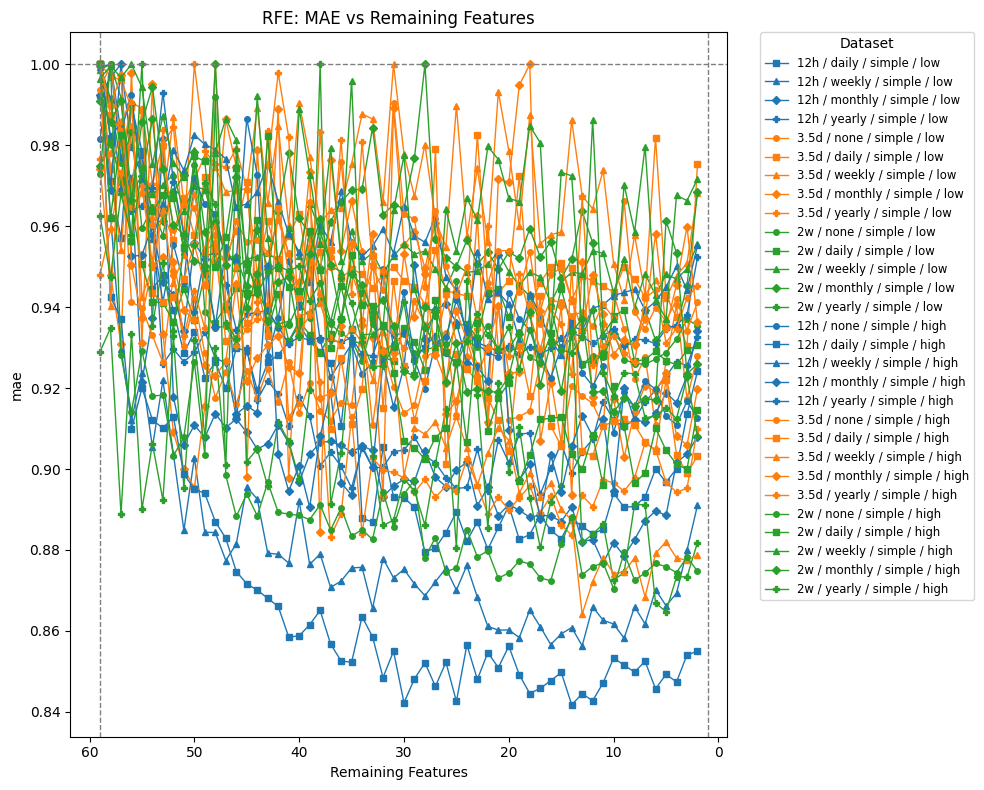

In [4]:
metric = 'mae'

plt.figure(figsize=(10, 8))

# Define dataset order for consistent appearance
data_order = [
    "12h / none / simple / low", "12h / daily / simple / low", "12h / weekly / simple / low", "12h / monthly / simple / low", "12h / yearly / simple / low",
    "3.5d / none / simple / low", "3.5d / daily / simple / low", "3.5d / weekly / simple / low", "3.5d / monthly / simple / low", "3.5d / yearly / simple / low", 
    "2w / none / simple / low", "2w / daily / simple / low", "2w / weekly / simple / low", "2w / monthly / simple / low", "2w / yearly / simple / low",

    "12h / none / simple / high", "12h / daily / simple / high", "12h / weekly / simple / high", "12h / monthly / simple / high", "12h / yearly / simple / high",
    "3.5d / none / simple / high", "3.5d / daily / simple / high", "3.5d / weekly / simple / high", "3.5d / monthly / simple / high", "3.5d / yearly / simple / high",
    "2w / none / simple / high", "2w / daily / simple / high", "2w / weekly / simple / high", "2w / monthly / simple / high", "2w / yearly / simple / high",

    "12h / none / complex / low", "12h / daily / complex / low", "12h / weekly / complex / low", "12h / monthly / complex / low", "12h / yearly / complex / low",
    "3.5d / none / complex / low", "3.5d / daily / complex / low", "3.5d / weekly / complex / low", "3.5d / monthly / complex / low", "3.5d / yearly / complex / low", 
    "2w / none / complex / low", "2w / daily / complex / low", "2w / weekly / complex / low", "2w / monthly / complex / low", "2w / yearly / complex / low",

    "12h / none / complex / high", "12h / daily / complex / high", "12h / weekly / complex / high", "12h / monthly / complex / high", "12h / yearly / complex / high",
    "3.5d / none / complex / high", "3.5d / daily / complex / high", "3.5d / weekly / complex / high", "3.5d / monthly / complex / high", "3.5d / yearly / complex / high",
    "2w / none / complex / high", "2w / daily / complex / high", "2w / weekly / complex / high", "2w / monthly / complex / high", "2w / yearly / complex / high",
]

# Define unique groups
time_groups = ["12h", "3.5d", "2w"]
freq_groups = ["none", "daily", "weekly", "monthly", "yearly"]
std_groups = ["low", "high"]

# Colors now based on time window
colors = plt.cm.tab10.colors[:len(time_groups)]
color_map = dict(zip(time_groups, colors))

# Markers now based on frequency
markers = ['o', 's', '^', 'D', 'P']  # 5 markers for the 5 frequencies
marker_map = dict(zip(freq_groups, markers))

# --- Plot ---
for ds in data_order:
    if ds not in rank_df_multi['dataset'].unique():
        continue

    time_part, freq_part, complexity_part, std_part = [x.strip() for x in ds.split('/')]

    values = rank_df_multi[rank_df_multi['dataset'] == ds]
    metric_values = values['baseline_metric']
    metric_values_scaled = metric_values / np.max(metric_values)
    remaining_features = values['iteration_removed'].max() - values['iteration_removed'] + 1

    plt.plot(
        remaining_features,
        metric_values_scaled,
        marker=marker_map.get(freq_part, 'o'),
        color=color_map.get(time_part, 'gray'),
        label=ds,
        linewidth=1,
        markersize=4
    )

# --- Axes and styling ---
plt.xlabel('Remaining Features')
plt.ylabel(metric)
plt.title(f'RFE: {metric.upper()} vs Remaining Features')

plt.axhline(y=1, color='gray', linestyle='--', linewidth=1)
plt.axvline(x=59, color='gray', linestyle='--', linewidth=1)
plt.axvline(x=1, color='gray', linestyle='--', linewidth=1)

plt.gca().invert_xaxis()

# --- Legend ---
plt.legend(
    title='Dataset',
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    borderaxespad=0.,
    fontsize='small'
)

plt.tight_layout()
plt.show()


In [5]:
# Get set of best feature_ids per dataset based on min baseline_metric

best_feat_sets = {}

for d, g in rank_df_multi.groupby("dataset"):
    # find the row with min baseline_metric
    best_idx = g['baseline_metric'].idxmin()
    iteration_thresh = g.loc[best_idx, 'iteration_removed']

    # filter rows with iteration_removed >= threshold
    feature_ids = set(g.loc[g['iteration_removed'] >= iteration_thresh, 'feature_id'])

    best_feat_sets[d] = feature_ids
    
for d, feats in best_feat_sets.items():
    print(f"Dataset: {d}, Best Features: {sorted(list(feats))}")

Dataset: 12h / daily / simple / high, Best Features: ['time_in_year / hour / sincos', 'time_in_year / second / numeric', 'time_in_year / week / numeric', 'time_since_last_event / day / numeric', 'time_since_last_event / hour / numeric', 'time_since_last_event / minute / numeric', 'time_since_last_event / month / numeric', 'time_since_last_event / second / numeric', 'time_since_last_event / week / numeric', 'time_since_start / hour / numeric', 'time_since_start / minute / numeric', 'time_since_start / month / numeric', 'time_since_start / second / numeric', 'time_since_start / week / numeric']
Dataset: 12h / daily / simple / low, Best Features: ['time_in_day / minute / numeric', 'time_in_day / minute / sincos', 'time_in_day / second / sincos', 'time_in_month / week / onehot', 'time_in_year / day / numeric', 'time_in_year / day / sincos', 'time_in_year / minute / numeric', 'time_in_year / month / sincos', 'time_in_year / second / sincos', 'time_in_year / week / numeric', 'time_since_last

### Number of features

In [6]:
for d, feats in best_feat_sets.items():
    print(f"Dataset: {d}, No. features in optimal set: {len(feats)}")

print()
print("Min. number of features in optimal sets:",
      np.min([len(feats) for feats in best_feat_sets.values()]))
print("Max. number of features in optimal sets:",
      np.max([len(feats) for feats in best_feat_sets.values()]))
print("Mean number of features in optimal sets:",
      np.mean([len(feats) for feats in best_feat_sets.values()]))
print("Median number of features in optimal sets:",
      np.median([len(feats) for feats in best_feat_sets.values()]))

# Count how many unique feature sets exist
unique_sets = set(frozenset(feats) for feats in best_feat_sets.values())

print("Number of unique optimal feature sets:", len(unique_sets))


Dataset: 12h / daily / simple / high, No. features in optimal set: 14
Dataset: 12h / daily / simple / low, No. features in optimal set: 28
Dataset: 12h / monthly / simple / high, No. features in optimal set: 17
Dataset: 12h / monthly / simple / low, No. features in optimal set: 11
Dataset: 12h / none / simple / high, No. features in optimal set: 10
Dataset: 12h / none / simple/ low, No. features in optimal set: 20
Dataset: 12h / weekly / simple / high, No. features in optimal set: 15
Dataset: 12h / weekly / simple / low, No. features in optimal set: 13
Dataset: 12h / yearly / simple / high, No. features in optimal set: 25
Dataset: 12h / yearly / simple / low, No. features in optimal set: 17
Dataset: 2w / daily / simple / high, No. features in optimal set: 11
Dataset: 2w / daily / simple / low, No. features in optimal set: 28
Dataset: 2w / monthly / simple / high, No. features in optimal set: 10
Dataset: 2w / monthly / simple / low, No. features in optimal set: 11
Dataset: 2w / none / s

### Feature sets

In [7]:
# Find intersection of best feature sets across selected datasets
datasets = list(DATASETS.keys())  # all datasets

datasets = [d for d in datasets if " / " in d]
#datasets = [d for d in datasets if " / " not in d]

#datasets = [d for d in datasets if "2w" in d]
#datasets = [d for d in datasets if "yearly" in d]
#datasets = [d for d in datasets if "high" in d]

#datasets = ["12h / daily / simple / low", "12h / daily / simple / high", "12h / daily / complex / low", "12h / daily / complex / high"]

cutoff = 0.7

print(len(datasets), "datasets selected")

30 datasets selected


In [8]:
best_feat_sets_type = {}
for dataset, featres in best_feat_sets.items():
    if dataset in datasets:
        feature_types = set()
        for feature in featres:
            type = feature.split(" / ")[0]
            feature_types.add(type)
        best_feat_sets_type[dataset] = feature_types
print(best_feat_sets_type)

best_feat_sets_granularity = {}
for dataset, featres in best_feat_sets.items():
    if dataset in datasets:
        granularities = set()
        for feature in featres:
            granularity = feature.split(" / ")[1]
            granularities.add(granularity)
        best_feat_sets_granularity[dataset] = granularities
print(best_feat_sets_granularity)

best_feat_sets_encoding = {}
for dataset, featres in best_feat_sets.items():
    if dataset in datasets:
        encodings = set()
        for feature in featres:
            encoding = feature.split(" / ")[2]
            encodings.add(encoding)
        best_feat_sets_encoding[dataset] = encodings
print(best_feat_sets_encoding)

best_feat_sets_type_granularity = {}
for dataset, featres in best_feat_sets.items():
    if dataset in datasets:
        type_granularities = set()
        for feature in featres:
            parts = feature.split(" / ")
            type = parts[0]
            granularity = parts[1]
            type_granularities.add(f"{type}-{granularity}")
        best_feat_sets_type_granularity[dataset] = type_granularities
print(best_feat_sets_type_granularity)

best_feat_sets_type_encoding = {}
for dataset, featres in best_feat_sets.items():
    if dataset in datasets:
        type_encodings = set()
        for feature in featres:
            parts = feature.split(" / ")
            type = parts[0]
            encoding = parts[2]
            type_encodings.add(f"{type}-{encoding}")
        best_feat_sets_type_encoding[dataset] = type_encodings
print(best_feat_sets_type_encoding)

best_feat_sets_granularity_encoding = {}
for dataset, featres in best_feat_sets.items():
    if dataset in datasets:
        granularity_encodings = set()
        for feature in featres:
            parts = feature.split(" / ")
            granularity = parts[1]
            encoding = parts[2]
            granularity_encodings.add(f"{granularity}-{encoding}")
        best_feat_sets_granularity_encoding[dataset] = granularity_encodings
print(best_feat_sets_granularity_encoding)

{'12h / daily / simple / high': {'time_since_last_event', 'time_in_year', 'time_since_start'}, '12h / daily / simple / low': {'time_in_month', 'time_in_year', 'utc', 'time_since_last_event', 'time_since_start', 'time_in_day'}, '12h / monthly / simple / high': {'time_since_last_event', 'time_in_month', 'time_in_week', 'time_since_start'}, '12h / monthly / simple / low': {'time_since_last_event', 'time_in_month', 'time_since_start'}, '12h / none / simple / high': {'time_in_month', 'time_in_year', 'time_since_last_event', 'time_since_start', 'time_in_day'}, '12h / none / simple/ low': {'time_in_month', 'time_in_year', 'time_in_week', 'utc', 'time_since_last_event', 'time_since_start', 'time_in_day'}, '12h / weekly / simple / high': {'time_in_year', 'time_in_week', 'time_since_last_event', 'time_in_day', 'time_since_start'}, '12h / weekly / simple / low': {'time_since_last_event', 'time_in_month', 'time_in_week', 'time_since_start'}, '12h / yearly / simple / high': {'time_in_month', 'time_

## Individual features

counts: Counter({'time_since_last_event / minute / numeric': 25, 'time_since_last_event / second / numeric': 25, 'time_since_last_event / hour / numeric': 23, 'time_since_start / week / numeric': 17, 'time_since_start / second / numeric': 17, 'time_since_start / minute / numeric': 16, 'time_since_start / hour / numeric': 16, 'time_since_start / month / numeric': 15, 'time_since_last_event / day / numeric': 15, 'utc / day / numeric': 13, 'time_since_last_event / week / numeric': 13, 'time_since_last_event / month / numeric': 12, 'time_since_start / day / numeric': 11, 'utc / second / numeric': 10, 'utc / month / numeric': 10, 'time_in_month / second / sincos': 9, 'time_in_year / minute / numeric': 8, 'time_in_year / day / numeric': 8, 'time_in_week / day / sincos': 8, 'time_in_month / day / sincos': 8, 'time_in_day / second / numeric': 8, 'utc / week / numeric': 7, 'utc / minute / numeric': 7, 'utc / hour / numeric': 7, 'time_in_month / minute / sincos': 7, 'time_in_year / month / sinco

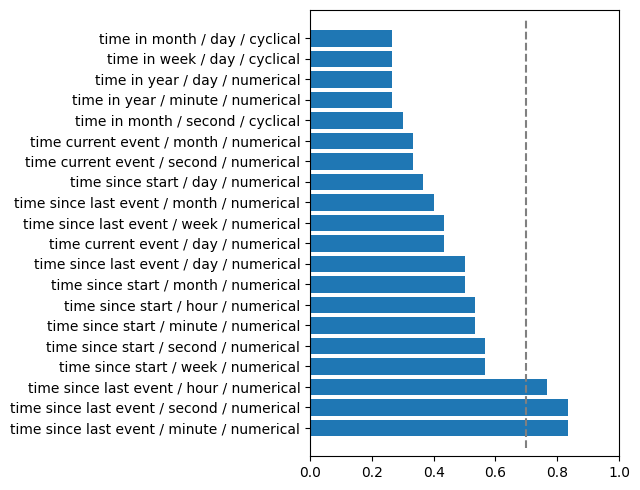

time since last event / minute / numerical
time since last event / second / numerical
time since last event / hour / numerical


In [9]:
# print counts 
cnt = Counter()
for d in datasets:
    cnt.update(best_feat_sets[d])     # count each appearance

print("counts:", cnt)

# sort by count (optional but usually nicer)
items = cnt.most_common()
items = items[:20]

# rename labels in line with paper definitions
labels = [x[0] for x in items]
labels = [lab.replace("utc", "time current event") for lab in labels]
labels = [lab.replace("time since start", "time since case start") for lab in labels]
labels = [lab.replace("_", " ") for lab in labels]
labels = [lab.replace("numeric", "numerical") for lab in labels]
labels = [lab.replace("sincos", "cyclical") for lab in labels]
labels = [lab.replace("onehot", "categorical") for lab in labels]


values = [x[1]/len(datasets) for x in items]

# bar plot
plt.figure(figsize=(6.5,5))
#plt.title('Representation of Features in Optimal Feature Sets (top 20)')
plt.vlines(x=cutoff, ymin=-1, ymax=len(labels), colors = 'gray', linestyles='--')
plt.xlim(0,1)
plt.barh(labels, values)
plt.tight_layout()
plt.show()


# print features with  >= cutoff
selected_labels = [lab for lab, val in zip(labels, values) if val >= cutoff]

for l in selected_labels:
    print(l)

## Single dimension

counts: Counter({'time_since_last_event': 30, 'time_since_start': 21, 'time_in_year': 19, 'time_in_month': 17, 'utc': 16, 'time_in_week': 15, 'time_in_day': 15})


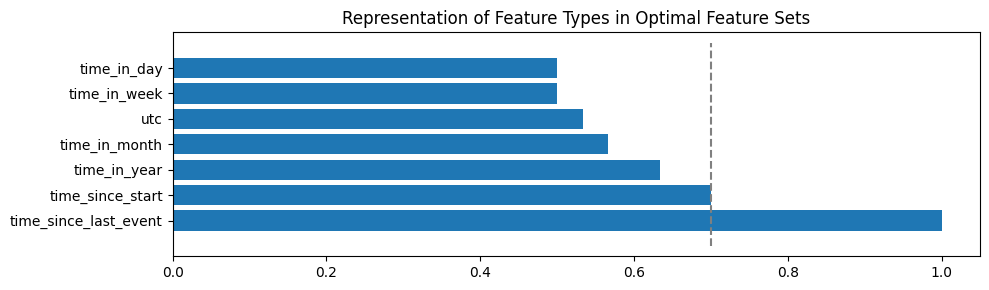

time_since_last_event
time_since_start


In [10]:
cnt = Counter()
for d in datasets:
    cnt.update(best_feat_sets_type[d])     # count each appearance

print("counts:", cnt)

# sort by count (optional but usually nicer)
items = cnt.most_common()
labels = [x[0] for x in items]
values = [x[1]/len(datasets) for x in items]


plt.figure(figsize=(10,3))
plt.title('Representation of Feature Types in Optimal Feature Sets')
plt.barh(labels, values)
plt.vlines(x=cutoff, ymin=-1, ymax=len(labels), colors = 'gray', linestyles='--')
plt.tight_layout()
plt.show()

# print features with  >= cutoff
selected_labels = [lab for lab, val in zip(labels, values) if val >= cutoff]

for l in selected_labels:
    print(l)

counts: Counter({'minute': 29, 'second': 28, 'hour': 27, 'day': 26, 'week': 25, 'month': 20})


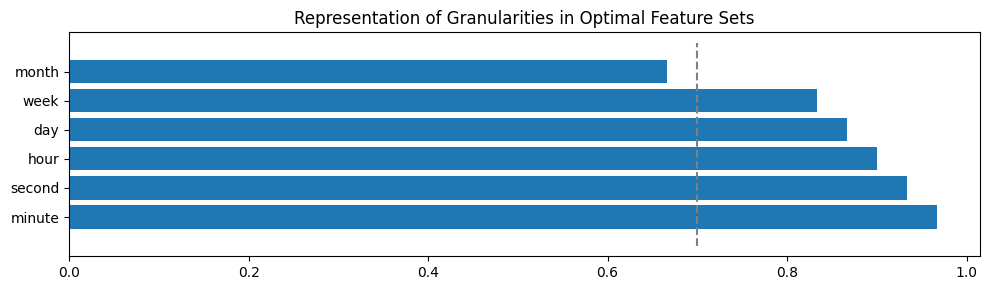

minute
second
hour
day
week


In [11]:
cnt = Counter()
for d in datasets:
    cnt.update(best_feat_sets_granularity[d])     # count each appearance

print("counts:", cnt)

# sort by count (optional but usually nicer)
items = cnt.most_common()
labels = [x[0] for x in items]
values = [x[1]/len(datasets) for x in items]


plt.figure(figsize=(10,3))
plt.title('Representation of Granularities in Optimal Feature Sets')
plt.barh(labels, values)
plt.vlines(x=cutoff, ymin=-1, ymax=len(labels), colors = 'gray', linestyles='--')
plt.tight_layout()
plt.show()

# print features with  >= cutoff
selected_labels = [lab for lab, val in zip(labels, values) if val >= cutoff]

for l in selected_labels:
    print(l)

counts: Counter({'numeric': 30, 'sincos': 24, 'onehot': 19})


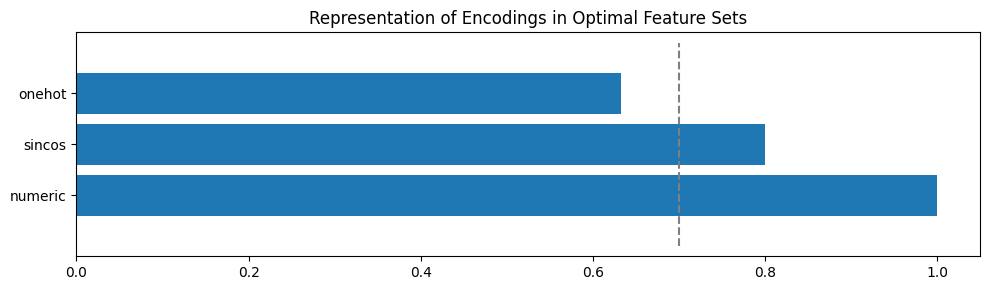

numeric
sincos


In [12]:
cnt = Counter()
for d in datasets:
    cnt.update(best_feat_sets_encoding[d])     # count each appearance

print("counts:", cnt)

# sort by count (optional but usually nicer)
items = cnt.most_common()
labels = [x[0] for x in items]
values = [x[1]/len(datasets) for x in items]


plt.figure(figsize=(10,3))
plt.title('Representation of Encodings in Optimal Feature Sets')
plt.barh(labels, values)
plt.vlines(x=cutoff, ymin=-1, ymax=len(labels), colors = 'gray', linestyles='--')
plt.tight_layout()
plt.show()

# print features with  >= cutoff
selected_labels = [lab for lab, val in zip(labels, values) if val >= cutoff]

for l in selected_labels:
    print(l)

[('time since last event', 1.0), ('time since start', 0.7), ('time in year', 0.6333333333333333), ('time in month', 0.5666666666666667), ('time current event', 0.5333333333333333), ('time in week', 0.5), ('time in day', 0.5)]
[('minute', 0.9666666666666667), ('second', 0.9333333333333333), ('hour', 0.9), ('day', 0.8666666666666667), ('week', 0.8333333333333334), ('month', 0.6666666666666666)]
[('numerical', 1.0), ('cyclical', 0.8), ('categorical', 0.6333333333333333)]


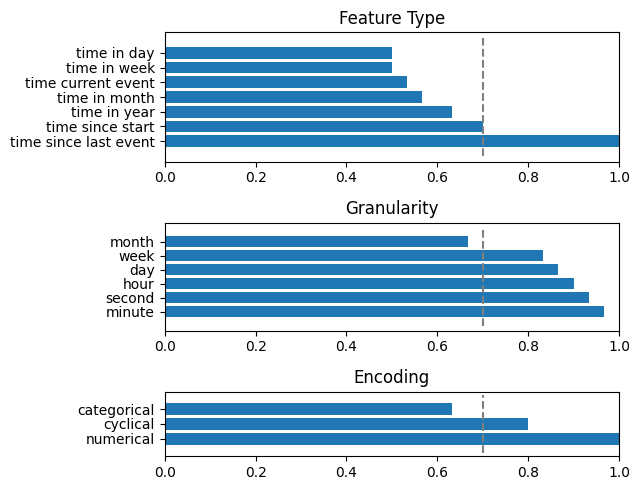

In [13]:
fig, axes = plt.subplots(3, 1, figsize=(6.5, 5), gridspec_kw={'height_ratios': [6, 5, 3]})
titles = [
    'Feature Type',
    'Granularity',
    'Encoding'
]

data_sources = [
    best_feat_sets_type,
    best_feat_sets_granularity,
    best_feat_sets_encoding
]

for ax, title, source in zip(axes, titles, data_sources):
    cnt = Counter()
    for d in datasets:
        cnt.update(source[d])
    
    items = cnt.most_common()
    labels = [x[0] for x in items]
    labels = [lab.replace("utc", "time current event") for lab in labels]
    labels = [lab.replace("time since start", "time since case start") for lab in labels]
    labels = [lab.replace("_", " ") for lab in labels]
    labels = [lab.replace("numeric", "numerical") for lab in labels]
    labels = [lab.replace("sincos", "cyclical") for lab in labels]
    labels = [lab.replace("onehot", "categorical") for lab in labels]

    values = [x[1]/len(datasets) for x in items]
    values = [x[1]/len(datasets) for x in items]

    ax.barh(labels, values)
    ax.set_title(title)
    ax.vlines(x=cutoff, ymin=-1, ymax=len(labels), color='gray', linestyles='--')
    ax.set_xlim(0, 1)
    print(list(zip(labels, values)))


plt.tight_layout()
plt.show()


daily [('time since last event', 1.0), ('time since start', 0.6666666666666666), ('time in year', 0.5), ('time current event', 0.5), ('time in day', 0.5), ('time in week', 0.3333333333333333), ('time in month', 0.16666666666666666)]
weekly [('time since last event', 1.0), ('time in week', 0.8333333333333334), ('time since start', 0.6666666666666666), ('time in year', 0.6666666666666666), ('time in day', 0.6666666666666666), ('time current event', 0.5), ('time in month', 0.3333333333333333)]
monthly [('time since last event', 1.0), ('time in month', 1.0), ('time since start', 0.8333333333333334), ('time in week', 0.5), ('time current event', 0.5), ('time in year', 0.3333333333333333), ('time in day', 0.3333333333333333)]
yearly [('time in year', 1.0), ('time since last event', 1.0), ('time in month', 0.6666666666666666), ('time current event', 0.6666666666666666), ('time since start', 0.5), ('time in week', 0.3333333333333333), ('time in day', 0.16666666666666666)]


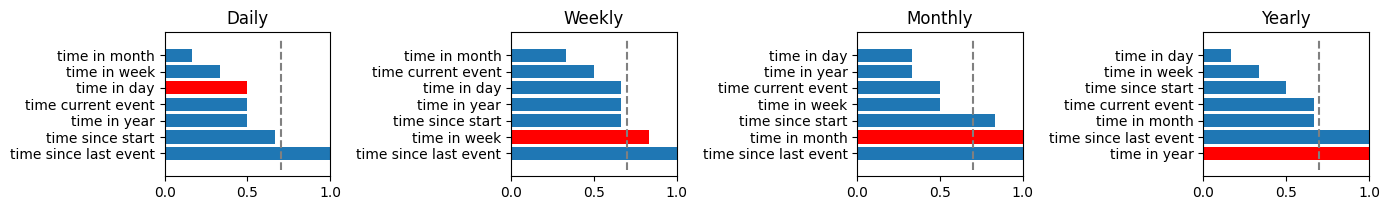

[1.0, 1.0, 0.6666666666666666, 0.6666666666666666, 0.5, 0.3333333333333333, 0.16666666666666666]


In [14]:
# Frequencies to show
#cyclicality_categories = ["none", "daily", "weekly", "monthly", "yearly"]
cyclicality_categories = ["daily", "weekly", "monthly", "yearly"]

fig, axes = plt.subplots(1, len(cyclicality_categories), figsize=(14, 2.2), sharex=True)
axes = axes.ravel()  # flatten for easy iteration

# Map frequencies to axes
axes_dict = {freq: ax for freq, ax in zip(cyclicality_categories, axes)}

# Plotting
for freq, ax in axes_dict.items():
    filtered_datasets = [d for d in datasets if freq in d.lower()]

    cnt = Counter()
    for d in filtered_datasets:
        cnt.update(best_feat_sets_type[d])

    items = cnt.most_common()
    if not items:
        ax.set_visible(False)
        continue

    labels = [x[0] for x in items]
    labels = [lab.replace("utc", "time current event") for lab in labels]
    labels = [lab.replace("time since start", "time since case start") for lab in labels]
    labels = [lab.replace("_", " ") for lab in labels]
    labels = [lab.replace("numeric", "numerical") for lab in labels]
    labels = [lab.replace("sincos", "cyclical") for lab in labels]
    labels = [lab.replace("onehot", "categorical") for lab in labels]


    values = [x[1]/len(filtered_datasets) for x in items]

    # Set colors for cyclicality columns
    colors = []
    for label in labels:
        if freq == "daily" and label == "time in day":
            colors.append("red")
        elif freq == "weekly" and label == "time in week":
            colors.append("red")
        elif freq == "monthly" and label == "time in month":
            colors.append("red")
        elif freq == "yearly" and label == "time in year":
            colors.append("red")
        else:
            colors.append("#1f77b4")  # default blue
        
    print(freq, list(zip(labels, values)))

    ax.barh(labels, values, color=colors)
    ax.set_title(f"{freq.capitalize()}")
    ax.vlines(x=cutoff, ymin=-1, ymax=len(labels), color='gray', linestyles='--')
    ax.set_xlim(0, 1)

plt.tight_layout()
plt.show()

print(values)

12h [('minute', 1.0), ('week', 1.0), ('hour', 1.0), ('second', 0.9), ('day', 0.9), ('month', 0.7)]
3.5d [('second', 1.0), ('minute', 0.9), ('hour', 0.9), ('day', 0.8), ('week', 0.7), ('month', 0.6)]
2w [('minute', 1.0), ('second', 0.9), ('day', 0.9), ('week', 0.8), ('hour', 0.8), ('month', 0.7)]


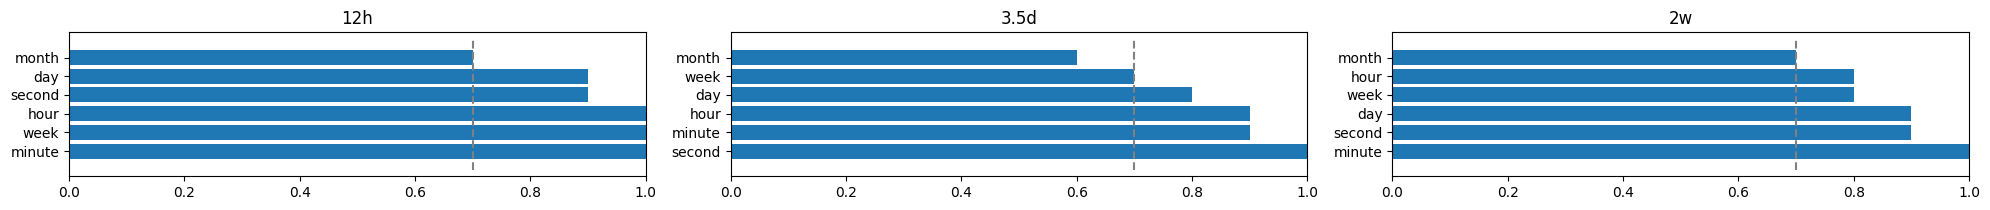

[1.0, 0.9, 0.9, 0.8, 0.8, 0.7]


In [15]:
# Frequencies to show
granularity_categories = ["12h", "3.5d", "2w"]

fig, axes = plt.subplots(1, len(granularity_categories), figsize=(20, 2.2), sharex=True)
axes = axes.ravel()  # flatten for easy iteration

# Map granularities to axes
axes_dict = {freq: ax for freq, ax in zip(granularity_categories, axes)}

# Plotting
for freq, ax in axes_dict.items():
    filtered_datasets = [d for d in datasets if freq in d.lower()]

    cnt = Counter()
    for d in filtered_datasets:
        cnt.update(best_feat_sets_granularity[d])

    items = cnt.most_common()
    if not items:
        ax.set_visible(False)
        continue

    labels = [x[0] for x in items]
    values = [x[1]/len(filtered_datasets) for x in items]

    # Set colors for cyclicality columns
    colors = []
    for label in labels:
        if freq == "daily" and label == "time_in_day":
            colors.append("red")
        elif freq == "weekly" and label == "time_in_week":
            colors.append("red")
        elif freq == "monthly" and label == "time_in_month":
            colors.append("red")
        elif freq == "yearly" and label == "time_in_year":
            colors.append("red")
        else:
            colors.append("#1f77b4")  # default blue
        
    print(freq, list(zip(labels, values)))

    ax.barh(labels, values, color=colors)
    ax.set_title(f"{freq.capitalize()}")
    ax.vlines(x=cutoff, ymin=-1, ymax=len(labels), color='gray', linestyles='--')
    ax.set_xlim(0, 1)

plt.tight_layout()
plt.show()

print(values)

## Two-was dimension combinations

counts: Counter({'time_since_last_event-minute': 25, 'time_since_last_event-second': 25, 'time_since_last_event-hour': 23, 'time_since_start-week': 17, 'time_since_start-second': 17, 'time_since_start-minute': 16, 'time_since_start-hour': 16, 'time_since_start-month': 15, 'time_since_last_event-day': 15, 'time_since_last_event-week': 13, 'utc-day': 13, 'time_since_last_event-month': 12, 'time_in_year-week': 12, 'time_in_week-day': 12, 'time_in_month-second': 11, 'time_in_year-minute': 11, 'time_since_start-day': 11, 'time_in_year-month': 11, 'utc-month': 10, 'utc-second': 10, 'time_in_year-second': 10, 'time_in_month-week': 10, 'time_in_month-day': 10, 'time_in_year-hour': 10, 'time_in_day-minute': 9, 'time_in_year-day': 9, 'time_in_day-second': 9, 'time_in_week-minute': 8, 'time_in_month-minute': 8, 'time_in_month-hour': 8, 'utc-hour': 7, 'utc-week': 7, 'utc-minute': 7, 'time_in_week-hour': 7, 'time_in_day-hour': 6, 'time_in_week-second': 5})


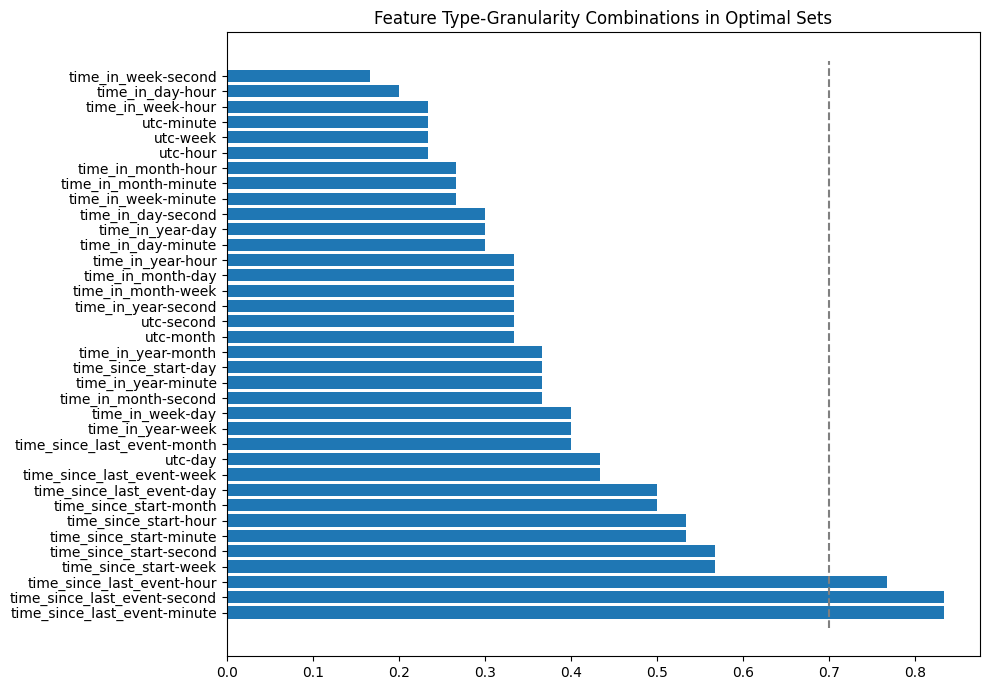

time_since_last_event-minute
time_since_last_event-second
time_since_last_event-hour


In [16]:
cnt = Counter()
for d in datasets:
    cnt.update(best_feat_sets_type_granularity[d])     # count each appearance

print("counts:", cnt)

# sort by count (optional but usually nicer)
items = cnt.most_common()
labels = [x[0] for x in items]
values = [x[1]/len(datasets) for x in items]


plt.figure(figsize=(10,7))
plt.title('Feature Type-Granularity Combinations in Optimal Sets')
plt.barh(labels, values)
plt.vlines(x=cutoff, ymin=-1, ymax=len(labels), colors = 'gray', linestyles='--')
plt.tight_layout()
plt.show()

# print features with  >= cutoff
selected_labels = [lab for lab, val in zip(labels, values) if val >= cutoff]

for l in selected_labels:
    print(l)

counts: Counter({'time_since_last_event-numeric': 30, 'time_since_start-numeric': 21, 'utc-numeric': 16, 'time_in_year-sincos': 13, 'time_in_day-numeric': 12, 'time_in_year-numeric': 11, 'time_in_month-sincos': 11, 'time_in_month-onehot': 10, 'time_in_day-sincos': 8, 'time_in_week-sincos': 8, 'time_in_year-onehot': 8, 'time_in_week-numeric': 6, 'time_in_week-onehot': 6, 'time_in_month-numeric': 6})


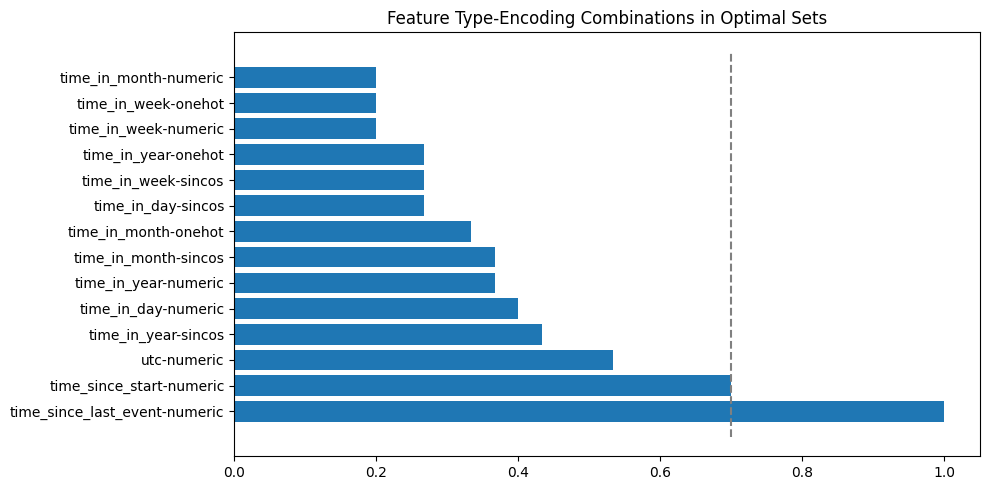

time_since_last_event-numeric
time_since_start-numeric


In [17]:
cnt = Counter()
for d in datasets:
    cnt.update(best_feat_sets_type_encoding[d])     # count each appearance

print("counts:", cnt)

# sort by count (optional but usually nicer)
items = cnt.most_common()
labels = [x[0] for x in items]
values = [x[1]/len(datasets) for x in items]


plt.figure(figsize=(10,5))
plt.title('Feature Type-Encoding Combinations in Optimal Sets')
plt.barh(labels, values)
plt.vlines(x=cutoff, ymin=-1, ymax=len(labels), colors = 'gray', linestyles='--')
plt.tight_layout()
plt.show()

# print features with  >= cutoff
selected_labels = [lab for lab, val in zip(labels, values) if val >= cutoff]

for l in selected_labels:
    print(l)

counts: Counter({'minute-numeric': 28, 'second-numeric': 28, 'hour-numeric': 27, 'day-numeric': 20, 'week-numeric': 19, 'month-numeric': 17, 'minute-sincos': 16, 'day-sincos': 16, 'hour-sincos': 16, 'second-sincos': 15, 'week-onehot': 11, 'day-onehot': 10, 'week-sincos': 9, 'month-sincos': 7, 'month-onehot': 4})


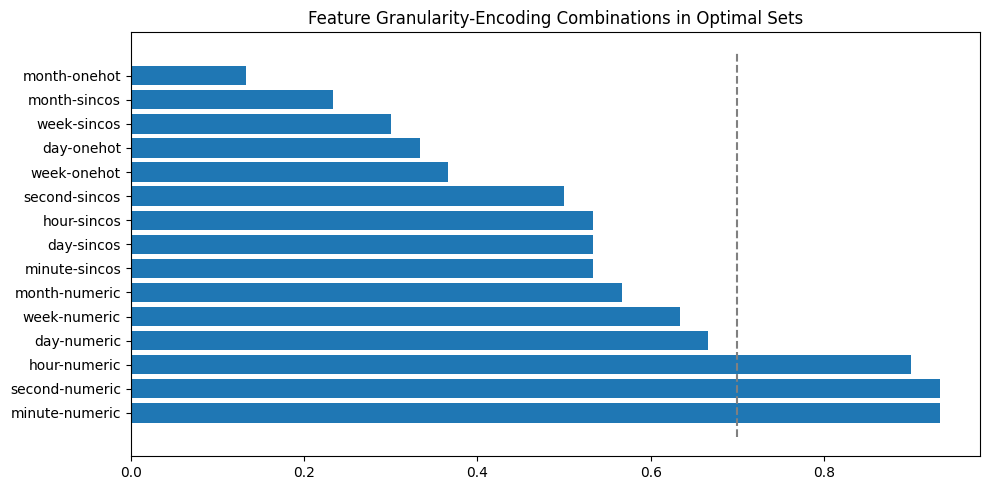

minute-numeric
second-numeric
hour-numeric


In [18]:
cnt = Counter()
for d in datasets:
    cnt.update(best_feat_sets_granularity_encoding[d])     # count each appearance

print("counts:", cnt)

# sort by count (optional but usually nicer)
items = cnt.most_common()
labels = [x[0] for x in items]
values = [x[1]/len(datasets) for x in items]


plt.figure(figsize=(10,5))
plt.title('Feature Granularity-Encoding Combinations in Optimal Sets')
plt.barh(labels, values)
plt.vlines(x=cutoff, ymin=-1, ymax=len(labels), colors = 'gray', linestyles='--')
plt.tight_layout()
plt.show()

# print features with  >= cutoff
selected_labels = [lab for lab, val in zip(labels, values) if val >= cutoff]

for l in selected_labels:
    print(l)